**Tutorial 8 - Markov Chain Monte Carlo**

In this tutorial we will learn how to construct a basic Metropolis-Hastings Markov Chain sampler and apply it to supernova data.


In [1]:
# 1) Make a Metropolis-Hastings stepping function.
#
# The function should take the following inputs 
# x - the current position in parameter space
# loglike - the value of the log of the likelihood 
#           evaluated at x
# loglike_func - a function that returns to log of the 
#            likelihood given a position in parameters space
# proposal_func - a proposal function that takes a position in 
#                  parameter space and proposes another
#
# The function should return the updated position, the updated 
# loglike and a boolean that is True if the proposed step was 
# accepted and False if it wasn't. 
# You can assume the proposal function is symmetric.

import pandas as pa
import numpy as np
import matplotlib.pyplot as plt
import random

def MH_step (x, loglike, loglike_func, proposal_func):
    x_new=proposal_func(x)
    val=np.random.uniform(0.,1.)
    if x_new[1]<0 or x_new[1]>1:  #these two lines prevent to have a negative omega matter 
        return x,loglike,False     #or a omega matter greater than 1
    loglike_new=loglike_func(x_new)
    ratio=np.exp(loglike_new-loglike)
    if ratio>=1:
        return x_new,loglike_new,True
    elif val < ratio:
        return x_new,loglike_new, True
    else:
        return x,loglike, False

In [2]:
# 2) Complete this code for a Gaussian proposal function class

class gaussian_transfer_function :
    
    ## This part is the constructor and 
    ## sets the internal information in the object
    # that is declared with
    # "func = gaussian_transfer_function(sigma_vector)"
    def __init__(self, sigma):
        self.n = len(sigma)
        self.s = sigma
    
    ##  This part defines what happens when 
    ##  you do "y = func(x)"
    ##  This should return a new point
    def __call__(self,x):
        return np.random.normal(x,self.s)


In [3]:
# 3) Make a Gaussian likelihood class of the form

class LogGaussianLikelihood :
    def __init__(self,y_data,x_data,y_model,sigma):
#         store the data, model and errors in the object
#         The function y_model(params,x_data) will return the 
#         predicted value for y to be compared to y_data
        self.y=y_data
        self.x=x_data
        self.y_model=y_model
        self.s=sigma
    
    def __call__(self,params):
#        Using the stored data and model to calculate 
#        the log of the Gaussian likelihood and return 
#        its value.
        return -0.5*np.sum(((self.y-self.y_model(params,self.x))/self.s)**2)

4) Write a function that returns the distance modulus with 
signature def mu_model(p,z). 

parameters p are 

p[0] is the absolute magnitude normalization 

p[1] is omega_matter.  

Use the library function 
astropy.cosmology.FlatLambdaCDM.luminosity_distance(z).value 
to calculate the luminosity distance.


In [4]:
import astropy.cosmology as cosmo
def mu_model(p,z):
    flat=cosmo.FlatLambdaCDM(H0=70,Om0=p[1])
    lum_dist=flat.luminosity_distance(z).value
    mu=5*np.log10(lum_dist)+p[0]
    return mu
    

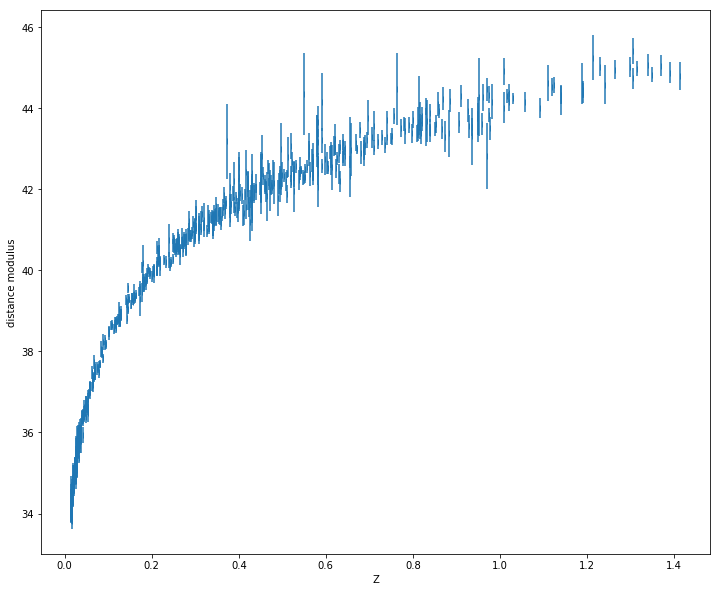

In [5]:
# Read in the supernova data
#
data = pa.read_csv("SCPUnion2.1_mu_vs_z.txt",sep='\t',comment='#')

z = data['redshift']
mu = data['dist_mod']
mu_err = data['dist_mod_error']

plt.figure(figsize=(12,10))
plt.errorbar(z,mu,yerr=mu_err,fmt='|')
plt.xlabel('Z')
plt.ylabel('distance modulus')
plt.show()

The acceptance is 37.55 %


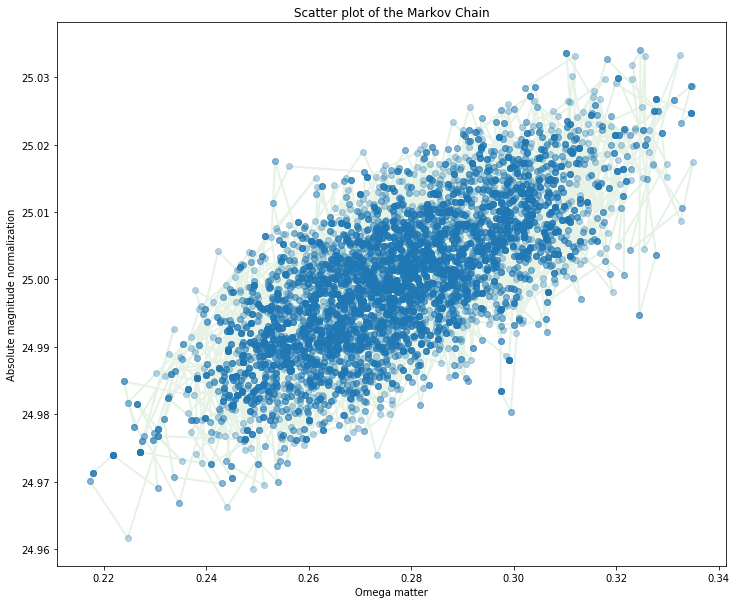

In [6]:
%matplotlib inline
np.random.seed(42)

# 5) 
## Make an instance of LogGaussianLikelihood with the data.
## Call it loglike_func
loglike_func=LogGaussianLikelihood(mu,z,mu_model,mu_err)

## Make an instance of gaussian_transfer_function
gauss_tran_func=gaussian_transfer_function([0.02,0.007])

## Set up the initial point p[] and its log likelihood 
## using  loglike_func(p)
p=[25,0.30]
log_likelihood=loglike_func(p)

## Make an MCMC loop 1000 steps or more long and make a scatter plot of 
## the chain.  Record the acceptance fraction.
iterations=10000
omegam=np.zeros(iterations)
M=np.zeros(iterations)
nsteps=0
for i in range(iterations):
    p,log_likelihood,step=MH_step(p,log_likelihood,loglike_func,gauss_tran_func)
    M[i]=p[0]
    omegam[i]=p[1]
    #print(log_likelihood)
    if step==True:
        nsteps = nsteps+1

print('The acceptance is '+str(100*nsteps/iterations)+' %')
#print(omegam)
#print(M)

plt.figure(figsize=(12,10))
plt.plot(omegam,M,alpha=0.1,zorder=1,lw=2,color='Green')
plt.scatter(omegam,M,alpha=0.3,zorder=2)
plt.xlabel('Omega matter')
plt.ylabel('Absolute magnitude normalization')
plt.title('Scatter plot of the Markov Chain')
plt.show()


6) Make historgrams of the two parameters.

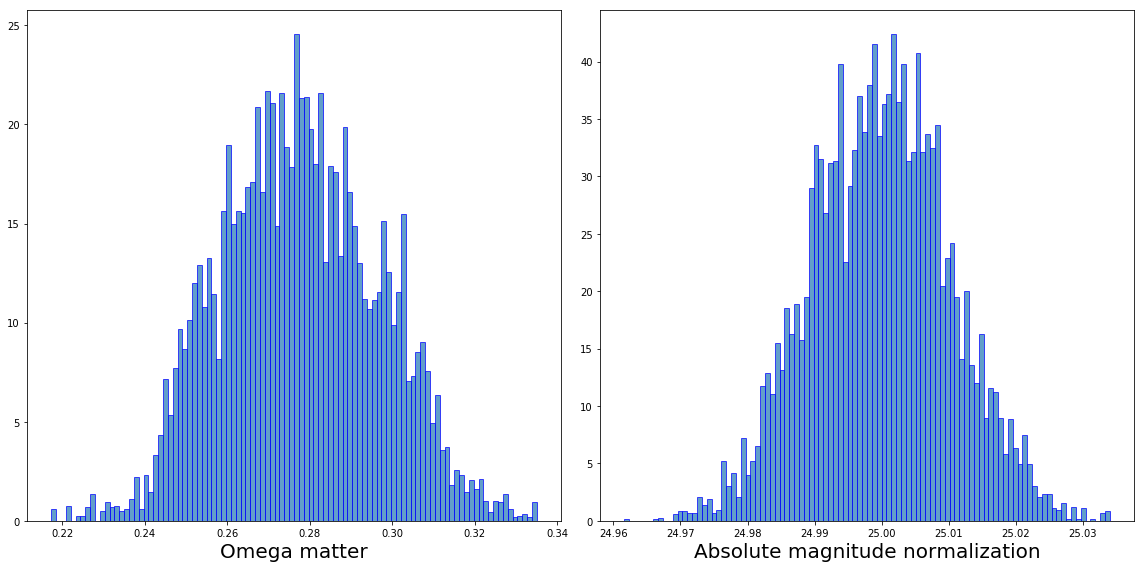

In [7]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(omegam,bins=int(np.sqrt(len(omegam))),alpha=0.7,edgecolor='blue',normed=True)
plt.xlabel('Omega matter',fontsize=20)

plt.subplot(1,2,2)
plt.hist(M,bins=int(np.sqrt(len(M))),alpha=0.7,edgecolor='blue',normed=True)
plt.xlabel('Absolute magnitude normalization',fontsize=20)
plt.tight_layout()
plt.show()

7) Use numpy.histogram2d() to make a 2 dimensional of the chain.

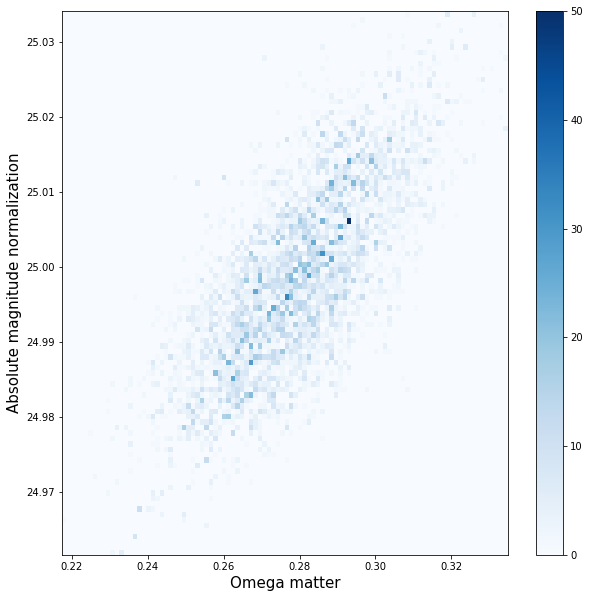

In [22]:
plt.figure(figsize=(10,10))
H, xedges, yedges = np.histogram2d(omegam, M, bins=(int(np.sqrt(len(omegam))),int(np.sqrt(len(M)))))
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H)
plt.colorbar()
plt.set_cmap('Blues')
#plt.title('Two dimensional histogram of the parameters')
plt.xlabel('Omega matter',fontsize=15)
plt.ylabel('Absolute magnitude normalization',fontsize=15)
plt.show()

In [9]:
## 8) Use this function to estimate the correlation length 
## of your chain. Plot the autocorrelation function for 
## lag zero to a few hundred.
def corrfunction(x,y):
    '''
    This function calculates the correlation coefficient 
    as a function of lag between 
    '''
    xc = x - np.mean(x)
    yc = y - np.mean(y)
    
    N = len(x)
    out = np.empty(N-2)
    stdx = np.std(xc)
    stdy = np.std(yc)

    for i in range(N-2) :
        xt = xc[0:N-i]
        yt = yc[i:N]
        if(stdx == 0 or stdy == 0):  ## this can happen for last elements
            out[i] = 0
        else :
            out[i] = np.mean(xt*yt)/stdx/stdy

    return out


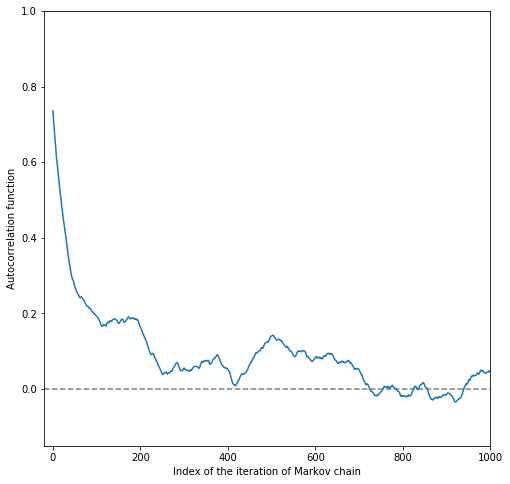

In [10]:
corr_lenght=corrfunction(omegam,M)
plt.figure(figsize=(8,8))
x=[-20,1000]
y=[0,0]
plt.plot(x,y,ls='--',alpha=0.5,color='black')
plt.plot(corr_lenght,alpha=1)
plt.axis([-20,1000,-0.15,1])
plt.xlabel('Index of the iteration of Markov chain')
plt.ylabel('Autocorrelation function')
plt.show()

8) Calculate the mean, variance and covariance of the parameters.

In [11]:
print('The mean value for Omega matter is '+str(np.mean(omegam))+' and its variance is '+str(np.var(omegam)))
print('The mean value for the absolute magnitude normalization is '+str(np.mean(M))+' and its variance is '+str(np.var(M)))
print('The normalized covariance matrix of the parameters is ')
cov=np.cov(omegam,M)
mat=np.array(([[omegam], [M]]))
for i in range(2):
    for j in range(2):
        cov[i][j]=cov[i][j]/(np.std(mat[i])*np.std(mat[j]))
print(cov)
print('Their normalized correlation coefficient is '+str(cov[0][1]))

The mean value for Omega matter is 0.277445708987628 and its variance is 0.00036202222592882034
The mean value for the absolute magnitude normalization is 24.99986533609502 and its variance is 0.0001061193449937562
The normalized covariance matrix of the parameters is 
[[1.00010001 0.73617844]
 [0.73617844 1.00010001]]
Their normalized correlation coefficient is 0.736178442283142
